# Task Description
"Pneumonia is an infection that inflames the air sacs (alveoli) in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia. Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems." ~ [MayoClinic](https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204#:~:text=Pneumonia%20is%20an%20infection%20that,and%20fungi%2C%20can%20cause%20pneumonia)

![https://www.nhlbi.nih.gov/sites/default/files/inline-images/pneumonia.png](https://www.nhlbi.nih.gov/sites/default/files/inline-images/pneumonia.png)

Chest X-Rays are an invaluable tool used in diagnosing pneumonia. This task requires us to build a model that can detect whether or not an inputted chest x-ray contains signs of pneumonia. The dataset that is part of this task contains 5,863 X-Ray images divided into 2 categories (Pneumonia/Normal).

# Imports

In [1]:
import sys
!conda install --yes --prefix {sys.prefix} timm

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / 

In [2]:
import sys
import os
import cv2
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as trf
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image, ImageFile
from torch.optim import lr_scheduler
import tqdm
import time
import timm as timm
import math
from sklearn.metrics import precision_recall_fscore_support
import joblib
import gc


import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


import torch.backends.cudnn as cudnn


seed = 100
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
cudnn.deterministic = True
cudnn.benchmark = False

# Exploration: X-Ray Visualisation
Exploring a dataset is an important first step in any machine learning project. This allows researchers and engineers to better understand not only the data they are working with, but also the overall task. 

We will first start by visualising a small subset of the chest x-ray images in the dataset. This should help us create a model tailored for our specific data.

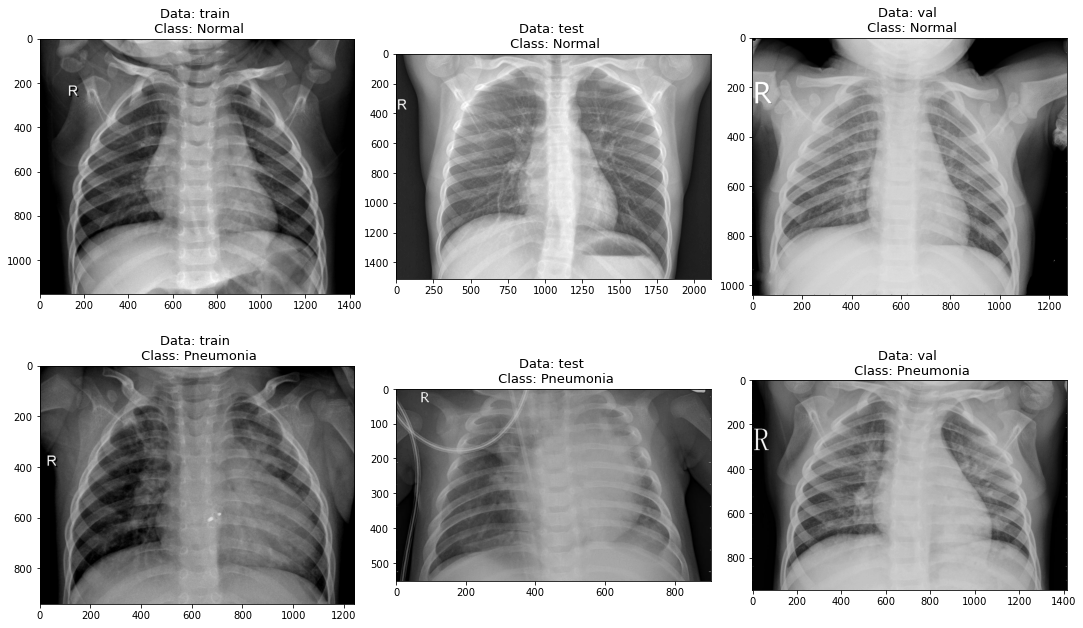

In [8]:
drct_path = Path('chest_xray/')

fig, ax = plt.subplots(2, 3, figsize = (15, 9))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'test', 'val']):
    set_path = drct_path.joinpath(_set)
    
    normal_img_path = set_path.joinpath('NORMAL')
    normal_img = plt.imread(normal_img_path.joinpath(os.listdir(normal_img_path)[1]))
    
    pneumonia_img_path = set_path.joinpath('PNEUMONIA')
    pneumonia_img = plt.imread(pneumonia_img_path.joinpath(os.listdir(pneumonia_img_path)[3]))
    
    ax[i].imshow(normal_img, cmap = 'gray')
    ax[i].set_title('Data: {} \n Class: Normal'.format(_set), fontsize = 13)
    ax[i+3].imshow(pneumonia_img, cmap = 'gray')
    ax[i+3].set_title('Data: {} \n Class: Pneumonia'.format(_set), fontsize = 13)

Looking at the above images, we can already make some interesting observations:
1. All images are greyscale, instead of RGB.
2. The brightness and contrast can vary significantly across the dataset.
3. The rotation of examined bodies can also vary.

Therefore, by visualising the dataset we discovered that we need to design a model that works with greyscale images, and is invariant to brightness, contrast, and rotation.

# Exploration: Class Balance
Understanding the class balance of a dataset is another crucial part of machine learning. A model that has been unknowingly trained on imbalanced data could result in unintended behaviour. For instance, it is common for models trained on heavily imbalanced data to only predict the class with highest representation, irrispective of what class should have been predicted. If we know there is a class balance issue early on, we can take measures to mitigate most issues.

In [9]:
train_normal_cnt = len(os.listdir(drct_path.joinpath('train', 'NORMAL')))
train_pneumonia_cnt = len(os.listdir(drct_path.joinpath('train', 'PNEUMONIA')))

val_normal_cnt = len(os.listdir(drct_path.joinpath('val', 'NORMAL')))
val_pneumonia_cnt = len(os.listdir(drct_path.joinpath('val', 'PNEUMONIA')))

test_normal_cnt = len(os.listdir(drct_path.joinpath('test', 'NORMAL')))
test_pneumonia_cnt = len(os.listdir(drct_path.joinpath('test', 'PNEUMONIA')))

total_normal_cnt = train_normal_cnt + val_normal_cnt + test_normal_cnt
total_pneumonia_cnt = train_pneumonia_cnt + val_pneumonia_cnt + test_pneumonia_cnt

print('Train counts')
print('Normal {} - {} Pneumonia'.format(train_normal_cnt, train_pneumonia_cnt))
print('\nVal counts')
print('Normal {} - {} Pneumonia'.format(val_normal_cnt, val_pneumonia_cnt))
print('\nTest counts')
print('Normal {} - {} Pneumonia'.format(test_normal_cnt, test_pneumonia_cnt))
print('\nTotal counts')
print('Normal {} - {} Pneumonia'.format(total_normal_cnt, total_pneumonia_cnt))

Train counts
Normal 1341 - 3875 Pneumonia

Val counts
Normal 8 - 8 Pneumonia

Test counts
Normal 234 - 390 Pneumonia

Total counts
Normal 1583 - 4273 Pneumonia


It is clear that this dataset is heavily biased towards cases of pneumonia. This will affect the way we process our dataset and evaluate our model.

# Configuration File

In [5]:
CONFIG = {
    'MEAN': [122.79749774, 122.79749774, 122.79749774],
    'STD': [61.01180544, 61.01180544, 61.01180544],
    'PNEUMONIA_ID': 1,
    'NORMAL_ID': 0,
    'image_dims': (224,224),
    'recalculate_dataset_stats': False,
    'max_pixel_val': 255.0,
    'batch_size': 16,
    'loader_workers': 4,
    'smoothing' : 0.00,
    't1' : 0.8,
    't2' : 1.2,
    'train_pkl_loc': 'train_data.pkl',
    'val_pkl_loc': 'val_data.pkl',
    'test_pkl_loc': 'test_data.pkl',
    'train_df_loc': 'train_df.pkl',
    'val_df_loc': 'val_df.pkl',
    'test_df_loc': 'test_df.pkl',
    
         }

# PreProcess Dataset
In this section we first index the dataset into train, validation, and test dataframes. During this process we also make sure that the dataset is balanced by replicating the under represented class. 

In most computer vision projects, the datasets are too large to be stored in memory. As such, it is common to load images individually per batch. The downside, however, is that this has noticable overhead, resulting in inefficient use of GPU time. In the following section, we preprocess the images into a dictionary that we later fully load into memory, speeding up the training process significantly. 

In [6]:
def index_dataset():
    # Index the train, validation, and test subsets into their relevant pandas dataframes. 
    # For each image we store the image class, file name, and file location.
    PNEUMONIA_ID = CONFIG['PNEUMONIA_ID']
    NORMAL_ID = CONFIG['NORMAL_ID']
    def build_df(subset, balance_dataset=False):
        cols = ['Class', 'Name', 'Location']
        rows = [[],[]]
        for cls, cls_id in [('NORMAL', NORMAL_ID), ('PNEUMONIA', PNEUMONIA_ID)]:
            path = drct_path.joinpath(subset, cls)
            locs = os.listdir(path)
            for name in locs:
                rows[cls_id].append([cls_id, name, path.joinpath(name)])
        if balance_dataset:
            # If we need to balance the dataset:
            # Replicate the class with lowest representation using the relevant ratio
            ratio = len(rows[PNEUMONIA_ID])/len(rows[NORMAL_ID])
            for i in range(int(ratio)-1):
                rows[NORMAL_ID].extend(rows[NORMAL_ID])
            remaining_diff = len(rows[PNEUMONIA_ID]) - len(rows[NORMAL_ID])
            rows[NORMAL_ID].extend(rows[NORMAL_ID][:remaining_diff])
            print('NORMAL: {}   -  PNEUMONIA: {}'.format(len(rows[NORMAL_ID]), len(rows[PNEUMONIA_ID])))
        rows[NORMAL_ID].extend(rows[PNEUMONIA_ID])
        rows = rows[NORMAL_ID]
        random.shuffle(rows)
        return pd.DataFrame(rows, columns=cols)
    
    train_df = build_df('train', balance_dataset=True)
    val_df = build_df('val')
    test_df = build_df('test')
    return train_df, val_df, test_df

def convert_dataset_to_list(df, save_loc, save_df_loc):
    # During development we noticed that the whole dataset can fit into RAM. 
    # Therefore, we load all the images into a dictionary using the same indexing as the dataframe.
    # To reduce memory usage, we resize the images beforehand, instead of performing that as part of the augmentation pipeline.
    path = Path(save_loc)
    path_df = Path(save_df_loc)
    if not path.exists():
        rsz = trf.Resize(CONFIG['image_dims'])
        new_dataset = {}
        with tqdm.tqdm(total=len(df)) as pbar:
            for index, row in df.iterrows():
                image_location = row['Location']
                image = Image.open(image_location).convert('RGB')
                image = rsz(image)
                new_dataset[index] = image
                pbar.update(1)
        joblib.dump(new_dataset, path)
        joblib.dump(df, path_df)
    new_dataset = None
    gc.collect()
    new_dataset = joblib.load(path)
    new_df = joblib.load(path_df)
    return new_dataset, new_df
    
        

def calculate_dataset_stats(locations_df):
    # Calculate mean and std of input dataframe images
    length = len(train_df)
    print(length)
    img_stack = []
    for idx in range(length):
        img = Image.open(locations_df.iloc[idx]['Location']).convert('RGB')
        rsz = trf.Resize(CONFIG['image_dims'])
        img2 = rsz.forward(img)
        img_stack.append(np.array(img2))

    img_stack = np.stack(img_stack)
    img_stack = np.einsum('ijkl->lijk', img_stack).reshape((3,-1))
    mean = np.mean(img_stack, -1)
    std = np.std(img_stack, -1)
    
    CONFIG['MEAN'] = mean
    CONFIG['STD'] = std
    print(mean, std)

In [7]:
train_df, val_df, test_df = index_dataset()
if CONFIG['recalculate_dataset_stats']:
    calculate_dataset_stats(train_df)
train_data, train_df = convert_dataset_to_list(train_df, CONFIG['train_pkl_loc'], CONFIG['train_df_loc'])
val_data, val_df = convert_dataset_to_list(val_df, CONFIG['val_pkl_loc'], CONFIG['val_df_loc'])
test_data, test_df = convert_dataset_to_list(test_df, CONFIG['test_pkl_loc'], CONFIG['test_df_loc'])
gc.collect()

  0%|          | 3/7750 [00:00<05:42, 22.62it/s]

NORMAL: 3875   -  PNEUMONIA: 3875


100%|██████████| 624/624 [00:14<00:00, 43.92it/s]


0

# Dataset Class

In [8]:
class XRayDataset(Dataset):
    """
    Class to read and load the XRay dataset from disk
    """
    def __init__(self, df, transform=None, fmix=False, data=None):
        self.transform = transform
        self.df = df
        self.fmix = fmix
        self.fmix_params={
                     'alpha': 1.0, 
                     'decay_power': 3.0, 
                     'shape': CONFIG['image_dims'],
                     'max_soft': True, 
                     'reformulate': False
                 }
        self.data = data

    def __len__(self):
        return len(self.df)
    
    def transform_image(self, img):
        if self.transform is not None:
            return self.transform(img)
    
    def __getitem__(self, idx):
        if self.data is None:
            image_location = self.df.iloc[idx]['Location']
            image = Image.open(image_location).convert('RGB')
        else:
            image = self.data[idx]
        image = self.transform_image(image)
        label = self.df.iloc[idx]['Class']              
        return image, label

# Data Augmentation

Data augmentation is crucial in preventing the model from overfitting during training. In short, this is the process of transforming the training data without, for the most part, altering the target classification. In general, data augmentation helps by training the model to be robust to the different kinds of noise that is present in real world data. For example, if we have an image of a dog, the position, size, and orientation of the dog does not change the fact that there is a dog in the image. Therefore, the model should still output the same target classification for all those variations. By augmenting the data, we are also training on an expanded the dataset. This allows the model to explore a wider range of the input space, resulting in a more informed decision boundary.

![https://miro.medium.com/max/640/0*Ci5g5EE4pfSCzV3o.jpg](https://miro.medium.com/max/640/0*Ci5g5EE4pfSCzV3o.jpg)

For this project in particular, data augmentation is also useful in indirectly helping to balance the dataset. As we discussed earlier, the least represented class had its images replicated by a particular ratio. In other words, the model will be training on the same image multiple times in the same epoch, possibly resulting in a heavily biased model. However, since we will be randomly augmenting the training data, every duplicated image is likely to be augmented differently. Thus, effectively, the model will be trained on unique images, even if the original batch had repeated data. 


In [9]:
def get_train_transforms():
    mean = np.array(CONFIG['MEAN']) / CONFIG['max_pixel_val']
    std = np.array(CONFIG['STD']) / CONFIG['max_pixel_val']
    return trf.Compose([
#             trf.Resize(CONFIG['image_dims']),
            trf.ColorJitter(brightness=0.2, contrast=0.1),
            trf.RandomAffine(degrees=20.0, translate=None, scale=None),
            trf.ToTensor(),
            trf.Normalize(mean, std)
        ])

def get_eval_transforms():
    mean = np.array(CONFIG['MEAN']) / CONFIG['max_pixel_val']
    std = np.array(CONFIG['STD']) / CONFIG['max_pixel_val']
    return trf.Compose([
            trf.Resize(CONFIG['image_dims']),
            trf.ToTensor(),
            trf.Normalize(mean, std)
        ])
        

As we pointed out in the Dataset Visualisation section, the dataset has different kinds of noise that need to be accounted for. These are mainly: x-ray brightness, contrast, and body rotation. Therefore, we designed the following augmentation pipeline:
1. Randomly alter the brightness of the x-ray by up to 20%
2. Randomly alter the contrast by up to 10%
3. Randomly rotate the x-ray by up to 20 degrees

# Data Loaders

In [10]:
def get_data_loaders(train_df, val_df, test_df, train_data, val_data, test_data):
    eval_transforms = get_eval_transforms()
    
    train = XRayDataset(train_df, transform=get_train_transforms(), fmix=False, data=train_data)
    val = XRayDataset(val_df, transform=get_eval_transforms(), data=val_data)
    test = XRayDataset(test_df, transform=get_eval_transforms(), data=test_data)
    
    train_loader = DataLoader(train, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['loader_workers'], drop_last=False)
    val_loader = DataLoader(val, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['loader_workers'], drop_last=False)
    test_loader = DataLoader(test, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['loader_workers'], drop_last=False)
    
    return train_loader, val_loader, test_loader

In [11]:
train_loader, val_loader, test_loader = get_data_loaders(train_df, val_df, test_df, train_data, val_data, test_data)

# Model: Pre-Trained Vision Transformer
Until recently, most computer vision tasks have relied solely on convolutional architectures. With the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929), researchers have now found a way of applying transformers directly to images, without any major architectural modifications. To do so, ViT first splits an image into a sequence of patches, projecting them into a sequence of embeddings. Subsequently, ViT propagates these dynamic patch embeddings through a standard transformer encoder to generate a task-specific output. The model architecture is shown in the image below.

![https://i.imgur.com/DXnJVqS.png](https://i.imgur.com/DXnJVqS.png)

The original paper explores multiple ways of projecting the inputted image into embeddings. The simplest option is to divide the image into flattened patches and transforming them using a learned linear projection. The other is to have a more hybrid approach using Convolutional Neural Networks (CNNs). The input embeddings could instead be generated by segmenting the feature maps of any CNN into patches, and projecting them into dynamic embeddings that can be propagated through a transformer.

In [12]:
class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        self.feature_extractor = timm.create_model('vit_small_resnet50d_s3_224', num_classes=2, attn_drop_rate=0.0, drop_path_rate=0.0,pretrained=True)

    def forward(self, x):
        out = x
        out = self.feature_extractor(out)  
        return out

In this project we use a pre-trained, hybrid ViT that uses a ResNet to extract feature maps from the inputted image. This allows the transformer to receive more informative features as input.

# Bi-Tempered Logistic Loss

Research shows that convex losses commonly used for classification tasks, like the softmax loss, are not robust against outliers. This is partly due to their unbounded nature. An unbound function will return high loss values, resulting in large gradient updates for misclassified outliers. Consequently, this lack of robustness results in a decision boundary that is heavily influenced by singular outlying data points.

![https://i.imgur.com/WwdKojh.png](https://i.imgur.com/WwdKojh.png)

Another issue, particularly with the softmax loss, is the exponentially decaying tail of the softmax function itself. Whenever there are outliers close to the decision boundary, the short tail of the softmax forces the model to give them higher importance. In contrast, heavy-tailed alternatives significantly improve the robustness of the loss towards such outliers.

The [Robust Bi-Tempered Logistic Loss](https://papers.nips.cc/paper/2019/hash/8cd7775f9129da8b5bf787a063d8426e-Abstract.html) addresses these issues through a bounded loss with tail-heaviness. The researchers did this by replacing the log and softmax in the softmax loss, with their respective tempered versions. The boundedness and tail-heaviness can be controlled through two hyperparameters: t1 and t2. When 0 <= t1 < 1, the loss is bounded, while when t2 > 1, the loss has a heavy tail.

![https://i.imgur.com/pWLU7hT.png](https://i.imgur.com/pWLU7hT.png)

The difference between softmax (logistic) loss and the Bi-Tempered Logistic Loss is shown in the image below.

![https://i.imgur.com/ppp02AJ.png](https://i.imgur.com/ppp02AJ.png)



In [13]:
# Code taken from https://github.com/fhopfmueller/bi-tempered-loss-pytorch/blob/master/bi_tempered_loss_pytorch.py

def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

Instead of the traditional Binary Cross-Entropy Loss function, we opted for the [Robust Bi-Tempered Logistic Loss](https://papers.nips.cc/paper/2019/hash/8cd7775f9129da8b5bf787a063d8426e-Abstract.html) published in NeurIPS 2019. This should help the model's generalisation by learning a more robust decision boundary, despite the small amount of training data.

# Experiment Builder

In [14]:
class ExperimentBuilder(nn.Module):
    def __init__(self, network_model, num_epochs, train_data, val_data,
                 test_data, weight_decay_coefficient, lr, use_gpu):
        """
        Initializes an ExperimentBuilder object. Such an object takes care of running training and evaluation of a deep net
        on a given dataset. It also takes care of saving per epoch models and automatically inferring the best val model
        to be used for evaluating the test set metrics.
        :param network_model: A pytorch nn.Module which implements a network architecture.
        :param experiment_name: The name of the experiment. This is used mainly for keeping track of the experiment and creating and directory structure that will be used to save logs, model parameters and other.
        :param num_epochs: Total number of epochs to run the experiment
        :param train_data: An object of the DataProvider type. Contains the training set.
        :param val_data: An object of the DataProvider type. Contains the val set.
        :param test_data: An object of the DataProvider type. Contains the test set.
        :param weight_decay_coefficient: A float indicating the weight decay to use with the adam optimizer.
        :param use_gpu: A boolean indicating whether to use a GPU or not.
        :param continue_from_epoch: An int indicating whether we'll start from scrach (-1) or whether we'll reload a previously saved model of epoch 'continue_from_epoch' and continue training from there.
        """
        super(ExperimentBuilder, self).__init__()
    
        self.model = network_model
        
        if torch.cuda.device_count() > 1 and use_gpu:
            self.device = torch.cuda.current_device()
            self.model.to(self.device)
            self.model = nn.DataParallel(module=self.model)
            print('Use Multi GPU', self.device)
        elif torch.cuda.device_count() == 1 and use_gpu:
            self.device =  torch.cuda.current_device()
            self.model.to(self.device)  # sends the model from the cpu to the gpu
            print('Use GPU', self.device)
        else:
            print("use CPU")
            self.device = torch.device('cpu')  # sets the device to be CPU
            print(self.device)
        
            
#         self.model.reset_parameters()  # re-initialize network parameters
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        self.num_epochs = num_epochs
        
        self.optimizer = optim.Adam(self.parameters(), amsgrad=False, lr=lr,
                                    weight_decay=weight_decay_coefficient)
#         self.learning_rate_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, num_epochs)
        self.learning_rate_scheduler = self._create_lr_scheduler()


        self.state = dict()
        self.starting_epoch = 0

    def get_num_parameters(self):
        total_num_params = 0
        for param in self.parameters():
            total_num_params += np.prod(param.shape)

        return total_num_params

    def get_optimiser(self):
        return self.optimizer  
    
    def _create_lr_scheduler(self):
        num_epochs = self.num_epochs
        num_warmup_steps = 3
        num_cycles = 0.5

        # Code from huggingface optimisers
        def lr_lambda(current_step):
            if current_step < num_warmup_steps:
                return float(current_step) / float(max(1, num_warmup_steps))
            progress = float(current_step - num_warmup_steps) / float(max(1, num_epochs - num_warmup_steps))
            return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
        
        
        return optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda, -1)
    
    def run_train_iter(self, x, y):
            """
            Receives the inputs and targets for the model and runs a training iteration. Returns loss and accuracy metrics.
            :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
            :param y: The targets for the model. A numpy array of shape batch_size, num_classes
            :return: the loss and accuracy for this batch
            """
            self.train()
            x, y = x.float().to(device=self.device), y.long().to(
            device=self.device)  # send data to device as torch tensors
            out = self.model.forward(x)  # forward the data in the model

            loss = bi_tempered_logistic_loss(out, y, t1=CONFIG['t1'], t2=CONFIG['t2'], label_smoothing=CONFIG['smoothing'])
            
            self.optimizer.zero_grad()  # set all weight grads from previous training iters to 0
            loss.backward()  # backpropagate to compute gradients for current iter loss
            self.optimizer.step()  # update network parameters
            # self.learning_rate_scheduler.step(epoch=self.current_epoch)

            _, predicted = torch.max(out.data, 1)  # get argmax of predictions
            accuracy = np.mean(list(predicted.eq(y.data).cpu()))  # compute accuracy
            prec, rec, f1, _ = precision_recall_fscore_support(y.cpu().data.numpy(), predicted.cpu().data.numpy(), average='macro')
            return loss.cpu().data.numpy(), accuracy, prec, rec, f1
        
    def run_evaluation_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs an evaluation iterations. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.eval()  # sets the system to validation mode
        x, y = x.float().to(device=self.device), y.long().to(
            device=self.device)  # convert data to pytorch tensors and send to the computation device
        out = self.model.forward(x)  # forward the data in the model
        
        loss = bi_tempered_logistic_loss(out, y, t1=CONFIG['t1'], t2=CONFIG['t2'], label_smoothing=CONFIG['smoothing'])

        _, predicted = torch.max(out.data, 1)  # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu()))  # compute accuracy
        prec, rec, f1, _ = precision_recall_fscore_support(y.cpu().data.numpy(), predicted.cpu().data.numpy(), average='macro')
        return loss.cpu().data.numpy(), accuracy, prec, rec, f1
                                                                            
    def run_experiment(self):
        """
        Runs experiment train and evaluation iterations, saving the model and best val model and val model accuracy after each epoch
        :return: The summary current_epoch_losses from starting epoch to total_epochs.
        """
        print('Starting Training')
        print('Model Parameters: {}'.format(self.get_num_parameters()))
        total_losses = {"train_acc": [], "train_loss": [], "val_acc": [],
                        "val_loss": []}  # initialize a dict to keep the per-epoch metrics
        best_test_metrics = {'f1':0, 'acc':0, 'loss':0}
        best_val_loss = math.inf
        epochs_since_improv = 0
        for i, epoch_idx in enumerate(range(self.starting_epoch, self.num_epochs)):
            epoch_start_time = time.time()
            current_epoch_losses = {"train_acc": [], "train_loss": [], "train_f1": [], 
                                    "val_acc": [], "val_loss": [], "val_f1": [],
                                    "test_acc": [], "test_loss": [], "test_f1": []}
            self.current_epoch = epoch_idx
            with tqdm.tqdm(total=len(self.train_data)) as pbar_train:  # create a progress bar for training
                for idx, (x, y) in enumerate(self.train_data):  # get data batches
                    loss, accuracy, prec, rec, f1 = self.run_train_iter(x=x, y=y) # take a training iter step
                    self.learning_rate_scheduler.step()
                    current_epoch_losses["train_loss"].append(loss)  # add current iter loss to the train loss list
                    current_epoch_losses["train_acc"].append(accuracy)  # add current iter acc to the train acc list
                    current_epoch_losses["train_f1"].append(f1)  # add current iter f1 to the train acc list
                    pbar_train.update(1)
                    pbar_train.set_description("Epoch {} - loss: {:.4f}, acc: {:.4f}, F1: {:.4f}".format(self.current_epoch, loss, accuracy, f1))
            avg_train_loss = np.mean(np.array(current_epoch_losses["train_loss"]))
            avg_train_acc = np.mean(np.array(current_epoch_losses["train_acc"]))
            avg_train_f1 = np.mean(np.array(current_epoch_losses["train_f1"]))
            
            with tqdm.tqdm(total=len(self.val_data)) as pbar_val:  # create a progress bar for validation
                for x, y in self.val_data:  # get data batches
                    loss, accuracy, prec, rec, f1  = self.run_evaluation_iter(x=x, y=y)  # run a validation iter
                    current_epoch_losses["val_loss"].append(loss)  # add current iter loss to val loss list.
                    current_epoch_losses["val_acc"].append(accuracy)  # add current iter acc to val acc lst.
                    current_epoch_losses["val_f1"].append(f1)  # add current iter f1 to the train acc list
                    pbar_val.update(1)  # add 1 step to the progress bar
                    pbar_val.set_description("Epoch {} - loss: {:.4f}, acc: {:.4f}, F1: {:.4f}".format(self.current_epoch, loss, accuracy, f1))
            avg_val_loss = np.mean(np.array(current_epoch_losses["val_loss"]))
            avg_val_acc = np.mean(np.array(current_epoch_losses['val_acc']))
            avg_val_f1 = np.mean(np.array(current_epoch_losses['val_f1']))  
        
            with tqdm.tqdm(total=len(self.test_data)) as pbar_test:  # ini a progress bar
                for x, y in self.test_data:  # sample batch
                    loss, accuracy, prec, rec, f1 = self.run_evaluation_iter(x=x, y=y)  # compute loss and accuracy by running an evaluation step
                    current_epoch_losses["test_loss"].append(loss)  # save test loss
                    current_epoch_losses["test_acc"].append(accuracy)  # save test accuracy
                    current_epoch_losses["test_f1"].append(f1)  # save test accuracy
                    pbar_test.update(1)  # update progress bar status
                    pbar_test.set_description(
                        "loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))  # update progress bar string output
            
            test_acc = np.mean(np.array(current_epoch_losses['test_acc']))
            test_f1 = np.mean(np.array(current_epoch_losses['test_f1']))
            
            print("Test Acc: {:.4f}  -  Test F1: {:.4f} \n Val Loss: {:.4f}  -  Val Acc: {:.4f}  -  Val F1: {:.4f} \n Train Loss: {:.4f}  -  Train Acc: {:.4f} - Train F1: {:.4f}"
                  .format(test_acc, test_f1, avg_val_loss, avg_val_acc, avg_val_f1, avg_train_loss, avg_train_acc, avg_train_f1)) 
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_since_improv = 0
                best_test_metrics['f1'] = current_epoch_losses["test_f1"][-1]
                best_test_metrics['acc'] = current_epoch_losses["test_acc"][-1]
                best_test_metrics['loss'] = current_epoch_losses["test_loss"][-1]
            else:
                epochs_since_improv += 1
            
            if epochs_since_improv == 3:
                break
        print('Final Test Results \n', best_test_metrics)

In [15]:
seed = 100
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
cudnn.deterministic = True
cudnn.benchmark = False

model = ViTModel()
exp = ExperimentBuilder(network_model=model, num_epochs=20, train_data=train_loader, val_data=val_loader,
                 test_data=test_loader, weight_decay_coefficient=1e-3, lr=1e-4, use_gpu=True)
exp.run_experiment()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth" to /root/.cache/torch/hub/checkpoints/resnet50d_ra2-464e36ba.pth
  0%|          | 0/485 [00:00<?, ?it/s]

Use GPU 0
Starting Training
Model Parameters: 56746082


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch 0 - loss: 0.0393, acc: 0.9375, F1: 0.9307: 100%|█████████▉| 484/485 [02:18<00:00,  3.55it/s]/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 0/485 [00:00<?, ?it/s]

Test Acc: 0.9135  -  Test F1: 0.8901 
 Val Loss: 0.1946  -  Val Acc: 0.9375  -  Val F1: 0.9373 
 Train Loss: 0.1419  -  Train Acc: 0.9168 - Train F1: 0.9033


  0%|          | 0/485 [00:00<?, ?it/s]

Test Acc: 0.9022  -  Test F1: 0.8915 
 Val Loss: 0.1048  -  Val Acc: 0.9375  -  Val F1: 0.9373 
 Train Loss: 0.0672  -  Train Acc: 0.9675 - Train F1: 0.9644


  0%|          | 0/485 [00:00<?, ?it/s]

Test Acc: 0.9071  -  Test F1: 0.8847 
 Val Loss: 0.2363  -  Val Acc: 0.8750  -  Val F1: 0.8730 
 Train Loss: 0.0393  -  Train Acc: 0.9821 - Train F1: 0.9807


  0%|          | 0/485 [00:00<?, ?it/s]

Test Acc: 0.8798  -  Test F1: 0.8501 
 Val Loss: 0.0462  -  Val Acc: 1.0000  -  Val F1: 1.0000 
 Train Loss: 0.0416  -  Train Acc: 0.9800 - Train F1: 0.9782


  0%|          | 0/485 [00:00<?, ?it/s]

Test Acc: 0.8734  -  Test F1: 0.8306 
 Val Loss: 0.3485  -  Val Acc: 0.7500  -  Val F1: 0.7333 
 Train Loss: 0.0321  -  Train Acc: 0.9845 - Train F1: 0.9834


  0%|          | 0/485 [00:00<?, ?it/s]

Test Acc: 0.7676  -  Test F1: 0.6790 
 Val Loss: 0.2284  -  Val Acc: 0.8750  -  Val F1: 0.8730 
 Train Loss: 0.0250  -  Train Acc: 0.9883 - Train F1: 0.9875


loss: 0.2845, accuracy: 0.8125: 100%|██████████| 39/39 [00:04<00:00,  9.31it/s]

Test Acc: 0.8990  -  Test F1: 0.8782 
 Val Loss: 0.3535  -  Val Acc: 0.8750  -  Val F1: 0.8730 
 Train Loss: 0.0248  -  Train Acc: 0.9876 - Train F1: 0.9865
Final Test Results 
 {'f1': 0.9227053140096619, 'acc': 0.9375, 'loss': array(0.2312207, dtype=float32)}


# Final Test Results
F1 Score: 92.27%

Accuracy: 93.75%

# Conclusion
In this project, we have shown how to perform pneumonia detection from chest x-ray images using state-of-the-art transformers. During the dataset analysis process, we discovered a large imbalance between the classes. To remedy this, we balanced the data through repetitions and used carefully selected augmentations to mitigate some of the issues with our balancing methodology. Instead of using traditional loss functions, we opted for the Bi-Tempered Robust Logistic Loss for a more robust decision boundary. Finally, we fine-tuned a pre-trained Vision Transformer, achieving an F1 score of 92.27%. 